# Import

In [ ]:
!pip install PyWavelets
!pip install mne

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import mne
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time # To measure time

from scipy.fft import fft
from scipy.signal import detrend, butter, filtfilt

# Data Import

In [ ]:
def collect_eeg_data(folder_path):
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            file_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            data[filename] = raw.get_data()
    return data

def read_json_dicts(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    return pd.DataFrame(data_dict)

# Preprocessing

In [ ]:
def calculate_td_psd_features(epoch_data, fs, power_lambda=0.1, epsilon=1e-9):
    """
    Calculates the 7 TD-PSD features for a single EEG epoch (single channel).
    Based on equations in Amini et al., 2021.

    Args:
        epoch_data (np.ndarray): 1D numpy array for a single channel epoch.
        fs (float): Sampling frequency of the epoch data.
        power_lambda (float): Lambda for power transform normalization.
        epsilon (float): Small value to prevent log(0) or division by zero.

    Returns:
        np.ndarray: Array containing the 7 log-transformed TD-PSD features.
                    Returns NaNs if calculation fails.
    """
    n_samples = len(epoch_data)
    if n_samples == 0:
        return np.full(7, np.nan)

    # Detrend the signal (optional but often good practice)
    signal = detrend(epoch_data)

    # 1. Calculate Power Spectrum and Moments
    try:
        # FFT
        X = fft(signal)
        # Power Spectrum (One-sided, ignoring DC for moments perhaps?)
        # Frequencies for moments k: corresponds to frequency bins
        freqs = np.fft.fftfreq(n_samples, 1/fs)
        # Power spectrum P[k] = |X[k]|^2 / N
        P = np.abs(X)**2 / n_samples

        # Calculate moments m0, m2, m4
        # m_n = sum(f^n * P(f)) df - approximated by sum(k^n * P[k])
        # We use the magnitude of frequencies for k, ignore negative freqs?
        # Let's use Hjorth parameters definition based on time-domain variance
        # m0 = variance(signal) = total power (approx)
        m0_bar = np.sum(signal**2) / n_samples # Variance = mean square if mean is zero
        if m0_bar < epsilon: m0_bar = epsilon

        # m2 = variance of first derivative (activity)
        delta_x = np.diff(signal, n=1) * fs # Scale by fs? Hjorth doesn't explicitly scale by fs
        m2_bar = np.sum(delta_x**2) / (n_samples -1) # Use n_samples-1?
        if m2_bar < epsilon: m2_bar = epsilon


        # m4 = variance of second derivative (mobility)
        delta2_x = np.diff(signal, n=2) * (fs**2) # Scale by fs^2?
        m4_bar = np.sum(delta2_x**2) / (n_samples -2)
        if m4_bar < epsilon: m4_bar = epsilon


        # Apply power transform (Box-Cox with lambda=0 is log, this is slightly different)
        m0 = (m0_bar**power_lambda - 1) / power_lambda if power_lambda != 0 else np.log(m0_bar)
        m2 = (m2_bar**power_lambda - 1) / power_lambda if power_lambda != 0 else np.log(m2_bar)
        m4 = (m4_bar**power_lambda - 1) / power_lambda if power_lambda != 0 else np.log(m4_bar)

        # Ensure moments are positive after transform for log
        m0 = max(m0, epsilon)
        m2 = max(m2, epsilon)
        m4 = max(m4, epsilon)


    except Exception as e:
        print(f"Error calculating moments: {e}")
        return np.full(7, np.nan)

    features = np.zeros(7)

    # 2. Calculate Features f1, f2, f3
    try:
        features[0] = np.log(m0) # f1 = log(m0)
        # Check for valid subtractions
        if m0 <= m2: m0 = m2 + epsilon
        if m0 <= m4: m0 = m4 + epsilon
        features[1] = np.log(m0 - m2) # f2 = log(m0 - m2)
        features[2] = np.log(m0 - m4) # f3 = log(m0 - m4)

    except Exception as e:
         print(f"Error calculating f1, f2, f3: {e}")
         features[:3] = np.nan


    # 3. Calculate Feature f4 (Sparseness)
    try:
        denominator_sqrt = np.sqrt(max(m0 - m2, epsilon)) * np.sqrt(max(m0 - m4, epsilon))
        if denominator_sqrt < epsilon: denominator_sqrt = epsilon
        features[3] = np.log(m0 / denominator_sqrt) # f4 = log(S) = log(m0 / sqrt((m0-m2)(m0-m4)))
    except Exception as e:
         print(f"Error calculating f4 (Sparseness): {e}")
         features[3] = np.nan

    # 4. Calculate Feature f5 (Irregularity Factor - IF)
    # IF = (m4/m2) / (m2/m0) based on Hjorth parameters 'complexity'
    # Paper formula: sqrt(m4/m2) / sqrt(m2/m0) => m0*m4 / m2^2
    try:
        if m2 < epsilon: m2 = epsilon
        if_val = (m0 * m4) / (m2**2)
        features[4] = np.log(max(if_val, epsilon)) # f5 = log(IF)
    except Exception as e:
        print(f"Error calculating f5 (IF): {e}")
        features[4] = np.nan

    # 5. Calculate Feature f6 (Covariance - COV)
    # COV = std_dev / mean
    try:
        mean_val = np.mean(signal)
        std_dev_val = np.std(signal)
        if abs(mean_val) < epsilon: mean_val = np.sign(mean_val) * epsilon if mean_val != 0 else epsilon
        cov_val = std_dev_val / mean_val
        features[5] = np.log(max(abs(cov_val), epsilon)) # Log of magnitude? Paper isn't explicit if COV can be negative. Let's take abs.
    except Exception as e:
        print(f"Error calculating f6 (COV): {e}")
        features[5] = np.nan


    # 6. Calculate Feature f7 (Teager Energy Operator - TEO)
    try:
        # TEO(x[j]) = x[j]^2 - x[j-1]x[j+1]
        # Need to handle boundaries (pad or slice)
        teo_vals = signal[1:-1]**2 - signal[:-2] * signal[2:]
        sum_teo = np.sum(teo_vals)
        features[6] = np.log(max(abs(sum_teo), epsilon)) # Log of magnitude? Sum can be negative. Paper isn't explicit. Taking abs.
    except Exception as e:
        print(f"Error calculating f7 (TEO): {e}")
        features[6] = np.nan

    return features

In [ ]:

def preprocess_eegnet_minimal(eeg_data, fs, lowcut=1.0, highcut=40.0, order=5):
    """
    Applies minimal preprocessing suitable for models like EEGNet:
    Bandpass filtering and channel-wise standardization.

    Args:
        eeg_data (np.ndarray): Raw EEG data (n_channels, n_timesteps).
        fs (float): Original sampling frequency.
        lowcut (float): Lower cutoff frequency for bandpass filter (Hz).
        highcut (float): Upper cutoff frequency for bandpass filter (Hz).
        order (int): Order of the Butterworth filter.

    Returns:
        np.ndarray: Preprocessed EEG data (n_channels, n_timesteps).
    """
    n_channels, n_timesteps = eeg_data.shape
    processed_data = np.zeros_like(eeg_data)

    # 1. Bandpass Filter Design
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Ensure frequency bounds are valid
    if low <= 0 or high >= 1:
         print(f"Warning: Filter frequencies ({lowcut}Hz, {highcut}Hz) are invalid for Nyquist freq {nyq}Hz. Adjusting or skipping filter.")
         # Option: Skip filtering or adjust bounds
         b, a = None, None # Indicate filter skip
    else:
        try:
            b, a = butter(order, [low, high], btype='band')
        except ValueError as e:
            print(f"Warning: Could not design Butterworth filter (order={order}, freqs=[{low}, {high}]). Skipping filter. Error: {e}")
            b, a = None, None


    # 2. Apply Filter and Standardize Channel by Channel
    for i_ch in range(n_channels):
        channel_data = eeg_data[i_ch, :]

        # Apply filtering if filter design was successful
        if b is not None and a is not None:
             try:
                 filtered_data = filtfilt(b, a, channel_data)
             except Exception as e:
                 print(f"Warning: Filtering failed for channel {i_ch}. Using original data for this channel. Error: {e}")
                 filtered_data = channel_data # Use original if filtering fails
        else:
             filtered_data = channel_data # Use original if filter wasn't designed

        # Standardize (z-score normalization)
        mean = np.mean(filtered_data)
        std = np.std(filtered_data)
        if std > 1e-9: # Avoid division by zero
            processed_data[i_ch, :] = (filtered_data - mean) / std
        else:
            processed_data[i_ch, :] = filtered_data - mean # Only center if std is zero

    return processed_data

£Models

In [ ]:
class EEGNet(nn.Module):
    """
    EEGNet: compact CNN architecture for EEG-based BCIs.

    Implementation based on Lawhern et al. (2018):
    "EEGNet: A Compact Convolutional Neural Network for EEG-based Brain-Computer Interfaces"

    Args:
        n_channels (int): Number of EEG channels
        n_timesteps (int): Number of timesteps in the EEG signal
        num_classes (int): Number of output classes
        dropout_rate (float): Dropout probability
        F1 (int): Number of temporal filters
        D (int): Depth multiplier
        F2 (int): Number of pointwise filters
        kernel_length (int): Length of temporal kernel
        normalize (bool): Whether to use batch normalization
    """
    def __init__(self, n_channels, n_timesteps, num_classes, dropout_rate=0.5,
                 F1=8, D=2, F2=16, kernel_length=64, normalize=True):
        super(EEGNet, self).__init__()
        self.n_channels = n_channels
        self.n_timesteps = n_timesteps
        self.num_classes = num_classes
        self.normalize = normalize

        # Block 1: Temporal Convolution and Depthwise Spatial Convolution
        self.block1 = nn.Sequential(
            # Temporal Convolution
            nn.Conv2d(1, F1, kernel_size=(1, kernel_length), padding=(0, kernel_length//2), bias=False),
            nn.BatchNorm2d(F1) if normalize else nn.Identity(),

            # Depthwise Spatial Convolution
            nn.Conv2d(F1, F1 * D, kernel_size=(n_channels, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D) if normalize else nn.Identity(),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(dropout_rate)
        )

        # Block 2: Separable Convolution
        # Separable convolution consists of a depthwise temporal convolution followed by a pointwise convolution
        self.block2 = nn.Sequential(
            # Depthwise Temporal Convolution
            nn.Conv2d(F1 * D, F1 * D, kernel_size=(1, 16), padding=(0, 8), groups=F1 * D, bias=False),
            nn.BatchNorm2d(F1 * D) if normalize else nn.Identity(),

            # Pointwise Convolution
            nn.Conv2d(F1 * D, F2, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(F2) if normalize else nn.Identity(),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(dropout_rate)
        )

        # Calculate output feature size for the FC layer
        # after temporal convolution: n_timesteps (no change due to padding)
        # after first pooling: n_timesteps/4
        # after second pooling: n_timesteps/32
        self.out_features = F2 * (n_timesteps // 32)

        # Classification layer
        self.classifier = nn.Linear(self.out_features, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, n_channels, n_timesteps)
        # Reshape for 2D convolution
        x = x.unsqueeze(1)  # (batch_size, 1, n_channels, n_timesteps)

        # Apply blocks
        x = self.block1(x)  # (batch_size, F1*D, 1, n_timesteps/4)
        x = self.block2(x)  # (batch_size, F2, 1, n_timesteps/32)

        # Flatten for FC layer
        x = x.view(x.size(0), -1)  # (batch_size, F2 * (n_timesteps/32))

        # Classification
        x = self.classifier(x)  # (batch_size, num_classes)

        return x

# Define the class weights before using them in the function definition
default_class_weight = {
    0: 0.7941,   # A
    1: 0.8360,   # C
    2: 1.8364    # F
}



# Training

In [ ]:
# --- Modified Generic Training Function with Validation ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Generic function to train and validate a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader or None): DataLoader for the validation data. If None, validation is skipped.
        criterion (nn.Module): The loss function (e.g., nn.CrossEntropyLoss).
        optimizer (Optimizer): The optimizer (e.g., optim.Adam).
        num_epochs (int): Number of epochs to train for.
        device (torch.device): The device to train on (CPU or CUDA).

    Returns:
        None: Prints training and validation progress information directly.
    """
    model.to(device) # Move model to the designated device
    total_train_steps = len(train_loader)
    if val_loader:
        total_val_steps = len(val_loader)
    start_time = time.time()

    print(f"\n--- Training {model.__class__.__name__} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set the model to training mode
        epoch_train_loss = 0.0
        train_correct_predictions = 0
        train_total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            # Move data to the designated device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total_samples += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        avg_epoch_train_loss = epoch_train_loss / total_train_steps
        epoch_train_accuracy = 100 * train_correct_predictions / train_total_samples

        # --- Validation Phase ---
        if val_loader is not None:
            model.eval() # Set the model to evaluation mode
            epoch_val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad(): # Disable gradient calculations during validation
                for val_inputs, val_labels in val_loader:
                    # Move data to the designated device
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)

                    # Forward pass
                    val_outputs = model(val_inputs)
                    val_loss_batch = criterion(val_outputs, val_labels)

                    # Accumulate validation statistics
                    epoch_val_loss += val_loss_batch.item()
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total_samples += val_labels.size(0)
                    val_correct_predictions += (val_predicted == val_labels).sum().item()

            # Calculate average validation loss and accuracy for the epoch
            avg_epoch_val_loss = epoch_val_loss / total_val_steps
            epoch_val_accuracy = 100 * val_correct_predictions / val_total_samples

            # Print combined epoch results
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
                  f'Val Loss: {avg_epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')
        else:
            # Print only training results if no validation loader is provided
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%')

        # Note: model is already set back to train() mode at the start of the next epoch loop iteration

    end_time = time.time()
    print(f"Finished Training {model.__class__.__name__}. Total time: {end_time - start_time:.2f} seconds")
    # --- Consider saving the best model based on validation performance ---
    # (Logic for tracking best val_accuracy/lowest val_loss and saving model state_dict would go here)

# Evaluation

In [ ]:
def evaluate_and_compare_models(models, model_names, data_loader, device, num_classes):
    """
    Evaluate multiple trained models on the same dataset and plot ROC curves.

    Args:
        models (list): List of trained PyTorch models.
        model_names (list): List of model names for labeling.
        data_loader (DataLoader): DataLoader for validation or test set.
        device (torch.device): Device for model execution.
        num_classes (int): Total number of output classes.

    Returns:
        reports (dict): A dictionary of classification report DataFrames per model.
    """
    reports = {}
    plt.figure(figsize=(8, 6))

    for model, name in zip(models, model_names):
        if data_loader is None:
            print(f"Skipping {name}: data_loader is None.")
            continue

        model.eval()
        y_true, y_pred, y_probs = [], [], []

        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                y_probs.extend(probs)
                y_true.extend(y_batch.numpy())
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())

        # Print Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n=== {name} ===")
        print(f"Accuracy: {acc:.2f}%")

        # Print classification report
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        report_df = pd.DataFrame(report).transpose()
        display(report_df[["precision", "recall", "f1-score", "support"]])
        reports[name] = report_df

        # Compute ROC Curve (Micro-average for multiclass)
        y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
        y_probs = np.array(y_probs)

        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    # ROC Plot settings
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title("Micro-Averaged ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return reports

# Running

## Import the data

In [ ]:
import os

# Define paths - everything is in the same directory
folder_path_test = 'test'
folder_path_train = 'train'
folder_path_val = 'validate'
file_path_labels = 'labels.json'

# Load test data and labels
data_val = collect_eeg_data(folder_path_val)
data_test = collect_eeg_data(folder_path_test)
data_train = collect_eeg_data(folder_path_train)
data_labels = read_json_dicts(file_path_labels)

# Optional debugging to verify paths
print(f"Current directory: {os.getcwd()}")
print(f"Test folder exists: {os.path.exists(folder_path_test)}")
print(f"Train folder exists: {os.path.exists(folder_path_train)}")
print(f"Val folder exists: {os.path.exists(folder_path_val)}")
print(f"Labels file exists: {os.path.exists(file_path_labels)}")

Current directory: /home/tj2286/alz_det_ML/model-data/fixed_data_aug
Test folder exists: True
Train folder exists: True
Val folder exists: True
Labels file exists: True


## Preprocessing

First, we match the labels with the data sets

In [ ]:
# 1. Strip 'test/' or 'train/' prefix from data_labels.file_name
data_labels['file_name'] = data_labels['file_name'].str.replace(r'^(test/|train/)', '', regex=True)

# Build a mapping from base filename → label
label_map = dict(zip(data_labels['file_name'], data_labels['label']))

# 2. Create y_val and filter data_val
y_val = {}
for fn in list(data_val.keys()):
    if fn in label_map:
        y_val[fn] = label_map[fn]
# keep only matched entries in data_val
data_val = {fn: data_val[fn] for fn in y_val}

# 3. Create y_test and filter data_test
y_test = {}
for fn in list(data_test.keys()):
    if fn in label_map:
        y_test[fn] = label_map[fn]
data_test = {fn: data_test[fn] for fn in y_test}

# 4. Create y_train and filter data_train, handling augmented filenames
def get_base_filename(fn: str) -> str:
    """
    Remove augmentation suffix (_amplitude_scale, _noise, _time_shift) before '.set'.
    E.g. 'sub-002_eeg_chunk_0_noise.set' → 'sub-002_eeg_chunk_0.set'
    """
    return re.sub(r'_(amplitude_scale|noise|time_shift)(?=\.set$)', '', fn)

y_train = {}
for fn in list(data_train.keys()):
    base = get_base_filename(fn)
    if base in label_map:
        y_train[fn] = label_map[base]
# keep only matched entries in data_train
data_train = {fn: data_train[fn] for fn in y_train}

In [ ]:
# Set sampling frequency and disable bandpass by using lowcut=0 and highcut=fs
fs = 95

print("\n--- Applying Minimal Preprocessing WITHOUT Bandpass Filter (Only Standardization) ---")

# Process TEST set
X_test_processed = []
for fname, eeg in data_test.items():
    processed = preprocess_eegnet_minimal(eeg, fs)
    X_test_processed.append(processed)
print(f"Processed {len(X_test_processed)} test samples; example shape: {X_test_processed[0].shape}")

# Process VALIDATION set
X_val_processed = []
for fname, eeg in data_val.items():
    processed = preprocess_eegnet_minimal(eeg, fs)
    X_val_processed.append(processed)
print(f"Processed {len(X_val_processed)} validation samples; example shape: {X_val_processed[0].shape}")

# Process TRAIN set
X_train_processed = []
for fname, eeg in data_train.items():
    processed = preprocess_eegnet_minimal(eeg, fs)
    X_train_processed.append(processed)
print(f"Processed {len(X_train_processed)} train samples; example shape: {X_train_processed[0].shape}")



--- Applying Minimal Preprocessing WITHOUT Bandpass Filter (Only Standardization) ---
Processed 898 test samples; example shape: (19, 1425)
Processed 877 validation samples; example shape: (19, 1425)
Processed 10644 train samples; example shape: (19, 1425)


We turn datasets into tensors

In [ ]:
print("\n--- Converting processed data + labels into tensors & dataloaders ---")

# Helper ─ collect labels in the SAME iteration order as the list was built
def build_xy_tensors(X_processed_list, y_dict):
    """
    Align X and y by dict iteration order, encode y with LabelEncoder,
    and return (X_tensor, y_tensor).
    """
    if not X_processed_list:
        raise ValueError("The processed X list is empty!")

    # Preserve insertion order of the dict (Python 3.7+ guarantees this)
    filenames_order = list(y_dict.keys())

    # Sanity check
    if len(filenames_order) != len(X_processed_list):
        raise RuntimeError(
            f"Mismatch: len(X)={len(X_processed_list)} vs len(y)={len(filenames_order)}. "
            "Check data alignment."
        )

    # Build y list according to the same order we used when filling X_processed
    y_list = [y_dict[fname] for fname in filenames_order]

    # --- Label encoding ---
    # For consistency across splits, fit once on the union of all labels
    global _global_le  # use a single LabelEncoder instance
    if '_global_le' not in globals():
        _global_le = LabelEncoder()
        _global_le.fit(
            list(y_train.values()) +
            list(y_val.values())   +
            list(y_test.values())
        )

    y_encoded = _global_le.transform(y_list)

    # --- Convert to tensors ---
    X_np = np.array(X_processed_list)          # shape: (N, C, T)
    y_np = np.array(y_encoded, dtype=np.int64) # shape: (N,)

    X_tensor = torch.from_numpy(X_np).float()
    y_tensor = torch.from_numpy(y_np)          # long by default if dtype not set

    return X_tensor, y_tensor

# Build tensors for each split
X_train_tensor, y_train_tensor = build_xy_tensors(X_train_processed, y_train)

# Validation split
if X_val_processed:
    X_val_tensor, y_val_tensor = build_xy_tensors(X_val_processed, y_val)
else:
    X_val_tensor = torch.empty((0, *X_train_tensor.shape[1:]), dtype=torch.float32)
    y_val_tensor = torch.empty((0,), dtype=torch.long)

# Test split
if X_test_processed:
    X_test_tensor, y_test_tensor = build_xy_tensors(X_test_processed, y_test)
else:
    X_test_tensor = torch.empty((0, *X_train_tensor.shape[1:]), dtype=torch.float32)
    y_test_tensor = torch.empty((0,), dtype=torch.long)

# Log shapes
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val  : {X_val_tensor.shape}, y_val  : {y_val_tensor.shape}")
print(f"X_test : {X_test_tensor.shape}, y_test : {y_test_tensor.shape}")



--- Converting processed data + labels into tensors & dataloaders ---
X_train: torch.Size([10644, 19, 1425]), y_train: torch.Size([10644])
X_val  : torch.Size([877, 19, 1425]), y_val  : torch.Size([877])
X_test : torch.Size([898, 19, 1425]), y_test : torch.Size([898])


# Model

In [ ]:
num_classes =3   # Number of classes=
batch_size = 16
learning_rate = 0.001
num_epochs = 1    # Number of epochs (example, usually needs more)

In [ ]:
from sklearn.model_selection import ParameterSampler

def train_pipeline(
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    X_test_tensor,
    y_test_tensor,
    *,
    learning_rate=1e-3,
    batch_size=16,
    optimizer="Adam",
    class_weight=default_class_weight,
    dropout_rate=0.5,
    num_epochs=100,
    weight_decay=1e-4,
    F1=8,
    D=2,
    device=torch.device("cpu"),
    verbose=False
):
    """
    Full training pipeline for EEGNet model with hyperparameter tuning.

    Args:
        X_train_tensor: Training data features
        y_train_tensor: Training data labels
        X_val_tensor: Validation data features
        y_val_tensor: Validation data labels
        X_test_tensor: Test data features
        y_test_tensor: Test data labels
        learning_rate: Learning rate for optimizer
        batch_size: Batch size for training
        optimizer: Optimizer type ("Adam", "AdamW", or "SGD")
        class_weight: Class weights for loss function
        dropout_rate: Dropout rate for model
        num_epochs: Number of training epochs
        weight_decay: L2 regularization strength
        F1: Number of temporal filters in EEGNet
        D: Depth multiplier in EEGNet
        device: Device to run training on
        verbose: Whether to print verbose output

    Returns:
        model: Trained EEGNet model
        loaders: Dictionary of data loaders
    """
    # Create data loaders
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=True
    )

    val_loader, test_loader = None, None
    if X_val_tensor is not None and X_val_tensor.shape[0] > 0:
        val_loader = DataLoader(
            TensorDataset(X_val_tensor, y_val_tensor),
            batch_size=batch_size,
            shuffle=False
        )
    if X_test_tensor is not None and X_test_tensor.shape[0] > 0:
        test_loader = DataLoader(
            TensorDataset(X_test_tensor, y_test_tensor),
            batch_size=batch_size,
            shuffle=False
        )

    # Get dimensions and number of classes
    n_channels, n_timesteps = X_train_tensor.shape[1], X_train_tensor.shape[2]
    num_classes = len(_global_le.classes_)

    # Calculate F2 based on F1 and D
    F2 = F1 * D

    # Initialize EEGNet model
    model = EEGNet(
        n_channels=n_channels,
        n_timesteps=n_timesteps,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        F1=F1,
        D=D,
        F2=F2
    ).to(device)

    # Set up loss function with class weights if provided
    if class_weight is not None:
        if isinstance(class_weight, dict):
            cw_tensor = torch.tensor(
                [class_weight.get(i, 1.0) for i in range(num_classes)],
                dtype=torch.float32,
                device=device
            )
        else:
            cw_tensor = class_weight.to(device)
        criterion = nn.CrossEntropyLoss(weight=cw_tensor)
    else:
        criterion = nn.CrossEntropyLoss()

    # Set up optimizer
    opt_name = optimizer.lower()
    if opt_name == "adam":
        optim_obj = optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
    elif opt_name == "adamw":
        optim_obj = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
    elif opt_name == "sgd":
        optim_obj = optim.SGD(
            model.parameters(),
            lr=learning_rate,
            momentum=0.9,
            weight_decay=weight_decay
        )
    else:
        raise ValueError(f"Unsupported optimizer {optimizer}")

    # Train the model
    train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optim_obj,
        num_epochs,
        device
    )

    return model, {"train": train_loader, "val": val_loader, "test": test_loader}


# Hyperparameter tuning pipeline
def run_hyperparameter_tuning(
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    X_test_tensor,
    y_test_tensor,
    n_trials=10
):
    """
    Run hyperparameter tuning for EEGNet model.

    Args:
        X_train_tensor: Training data features
        y_train_tensor: Training data labels
        X_val_tensor: Validation data features
        y_val_tensor: Validation data labels
        X_test_tensor: Test data features
        y_test_tensor: Test data labels
        n_trials: Number of hyperparameter combinations to try

    Returns:
        best_model: Best trained model
        best_config: Best hyperparameter configuration
        best_acc: Best validation accuracy
    """
    # Initialize best trackers
    best_acc = 0.0
    best_config = None
    best_model = None
    best_model_path = './best_eegnet_model.pt'

    # Define search space for hyperparameters
    tune_space = {
        "learning_rate": np.logspace(-4, -2, num=100),  # continuous log space
        "batch_size": [16, 24, 32, 40, 48, 56, 64],
        "optimizer": ["Adam", "AdamW", "SGD"],
        "dropout_rate": np.linspace(0.3, 0.7, num=5),  # [0.3, 0.4, 0.5, 0.6, 0.7]
        "num_epochs": [30],
        "weight_decay": np.logspace(-3, -1, num=50),
        "F1": [5, 10, 19, 38, 47, 95],  # Number of temporal filters
        "D": [2, 3, 4, 5, 6, 7],        # Depth multiplier
    }

    # Sample random combinations
    drawer = list(ParameterSampler(tune_space, n_iter=n_trials, random_state=42))

    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Loop through each sampled config
    for idx, config in enumerate(drawer, 1):
        print(f"\n=== Configuration {idx}/{n_trials} ===")
        print(config)

        # Extract hyperparameters
        lr = config["learning_rate"]
        bs = config["batch_size"]
        opt_name = config["optimizer"]
        do_rate = config["dropout_rate"]
        epochs = config["num_epochs"]
        wd = config["weight_decay"]
        f1 = config["F1"]
        d = config["D"]

        # Train using the pipeline
        start_time = time.time()
        model, loaders = train_pipeline(
            X_train_tensor, y_train_tensor,
            X_val_tensor, y_val_tensor,
            X_test_tensor, y_test_tensor,
            learning_rate=lr,
            batch_size=bs,
            optimizer=opt_name,
            dropout_rate=do_rate,
            num_epochs=epochs,
            weight_decay=wd,
            F1=f1,
            D=d,
            device=device,
            verbose=False
        )
        train_time = time.time() - start_time
        print(f"Training time: {train_time:.2f} seconds")

        # Evaluate on validation set
        val_loader = loaders["val"]
        if val_loader is not None:
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for Xb, yb in val_loader:
                    Xb, yb = Xb.to(device), yb.to(device)
                    out = model(Xb)
                    pred = torch.argmax(out, dim=1)
                    correct += (pred == yb).sum().item()
                    total += yb.size(0)
            val_acc = 100 * correct / total
            print(f"Validation Accuracy: {val_acc:.2f}%")

            # Save model if it achieves a new best accuracy
            if val_acc > best_acc:
                best_acc = val_acc
                best_config = config
                best_model = model
                torch.save(model.state_dict(), best_model_path)
                print(f"--> New best model saved! (acc={best_acc:.2f}%)")

    # Print summary of best result
    print(f"\n==> Best Validation Accuracy: {best_acc:.2f}%")
    print("Best Hyperparameters:", best_config)
    print(f"Best model saved to: {best_model_path}")

    return best_model, best_config, best_acc

In [ ]:
best_model, best_config, best_acc = run_hyperparameter_tuning(
    X_train_tensor, y_train_tensor,
    X_val_tensor,   y_val_tensor,
    X_test_tensor,  y_test_tensor,
    10
)

In [ ]:
print(best_config)

In [ ]:
trained_model, loaders = train_pipeline(
    X_train_tensor, y_train_tensor,
    X_val_tensor,   y_val_tensor,
    X_test_tensor,  y_test_tensor,
    learning_rate = best_config["learning_rate"],
    batch_size    = best_config["batch_size"],
    optimizer     = best_config["optimizer"],
    class_weight  = {0:1.0, 1:1.5, 2:2.0},
    dropout_rate  =best_config["dropout_rate"],
    num_epochs    = 100
)

In [ ]:
trained_model, loaders = train_pipeline(
    X_train_tensor, y_train_tensor,
    X_val_tensor,   y_val_tensor,
    X_test_tensor,  y_test_tensor,
    learning_rate = 0.0006734150657750821,
    batch_size    = 56,
    optimizer     = "Adam",
    class_weight  = {0:1.0, 1:1.5, 2:2.0},
    dropout_rate  = 0.5,
    num_epochs    = 30
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

def evaluate_eegnet(
    model,
    data_loader,
    device,
    class_names=None,
    verbose=True,
    plot_confusion=True,
    plot_roc=True
):
    """
    Evaluate a trained EEGNet model on a dataset.

    Parameters:
    -----------
    model : nn.Module
        The trained EEGNet model to evaluate
    data_loader : DataLoader
        DataLoader for the evaluation dataset
    device : torch.device
        Device to run evaluation on
    class_names : list, optional
        Names of the classes for better reporting
    verbose : bool, default=True
        Whether to print evaluation results
    plot_confusion : bool, default=True
        Whether to plot confusion matrix
    plot_roc : bool, default=True
        Whether to plot ROC curves

    Returns:
    --------
    results : dict
        Dictionary containing evaluation metrics
    """
    if class_names is None and hasattr(data_loader.dataset, 'classes'):
        class_names = data_loader.dataset.classes

    # Ensure model is in evaluation mode
    model.to(device)
    model.eval()

    # Initialize lists to store predictions and ground truth
    y_true = []
    y_pred = []
    y_probs = []

    # Disable gradient calculations
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get probabilities and predictions
            probabilities = torch.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

            # Store results
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            y_probs.extend(probabilities.cpu().numpy())

    # Convert to numpy arrays for easier handling
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Get number of classes
    num_classes = len(np.unique(y_true)) if class_names is None else len(class_names)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)

    # Handle cases where some classes might not be present in the test set
    with np.errstate(divide='ignore', invalid='ignore'):
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create classification report
    if class_names is not None:
        report = classification_report(
            y_true, y_pred,
            target_names=class_names,
            output_dict=True,
            zero_division=0
        )
        report_df = pd.DataFrame(report).transpose()
    else:
        report = classification_report(
            y_true, y_pred,
            output_dict=True,
            zero_division=0
        )
        report_df = pd.DataFrame(report).transpose()

    # Prepare ROC curve data
    if num_classes == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_data = [(fpr, tpr, roc_auc, "ROC curve")]
    else:
        # Multi-class classification
        roc_data = []
        # One-vs-rest ROC curves for each class
        for i in range(num_classes):
            class_label = class_names[i] if class_names is not None else f"Class {i}"
            fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            roc_data.append((fpr, tpr, roc_auc, f"ROC curve for {class_label}"))

    # Print results if verbose
    if verbose:
        print(f"Accuracy: {accuracy*100:.2f}%")
        print(f"Precision: {precision*100:.2f}%")
        print(f"Recall: {recall*100:.2f}%")
        print(f"F1 Score: {f1*100:.2f}%")
        print("\nClassification Report:")
        print(report_df[["precision", "recall", "f1-score", "support"]])
        print("\nConfusion Matrix:")
        print(cm)

    # Plot confusion matrix
    if plot_confusion:
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()

        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, class_names if class_names else tick_marks)
        plt.yticks(tick_marks, class_names if class_names else tick_marks)

        # Add text annotations to the confusion matrix
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.show()

    # Plot ROC curves
    if plot_roc:
        plt.figure(figsize=(8, 6))
        for fpr, tpr, roc_auc, label in roc_data:
            plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    # Prepare results dictionary
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': report_df,
        'roc_data': roc_data,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_probs': y_probs
    }

    return results

In [ ]:
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    shuffle=False
)

evaluate_eegnet(
    model= trained_model,
    data_loader=test_loader,
    device=torch.device("cpu")
)

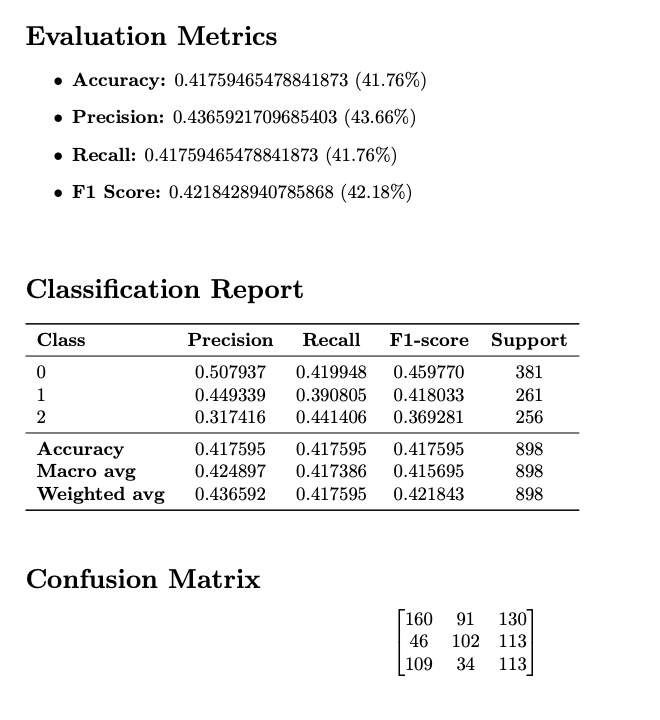

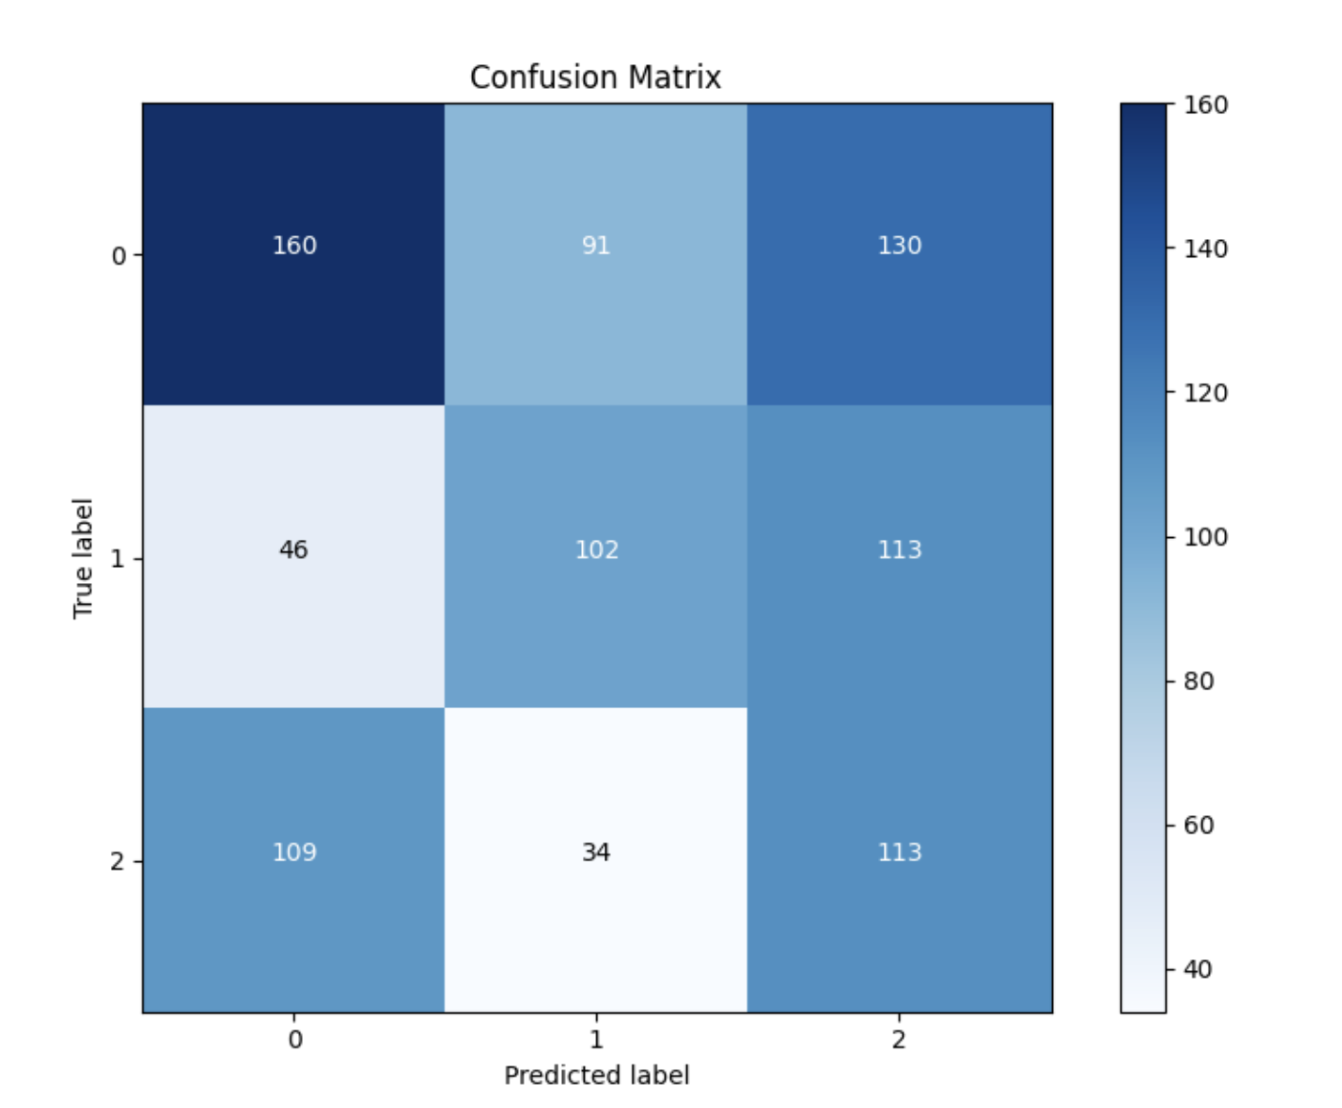

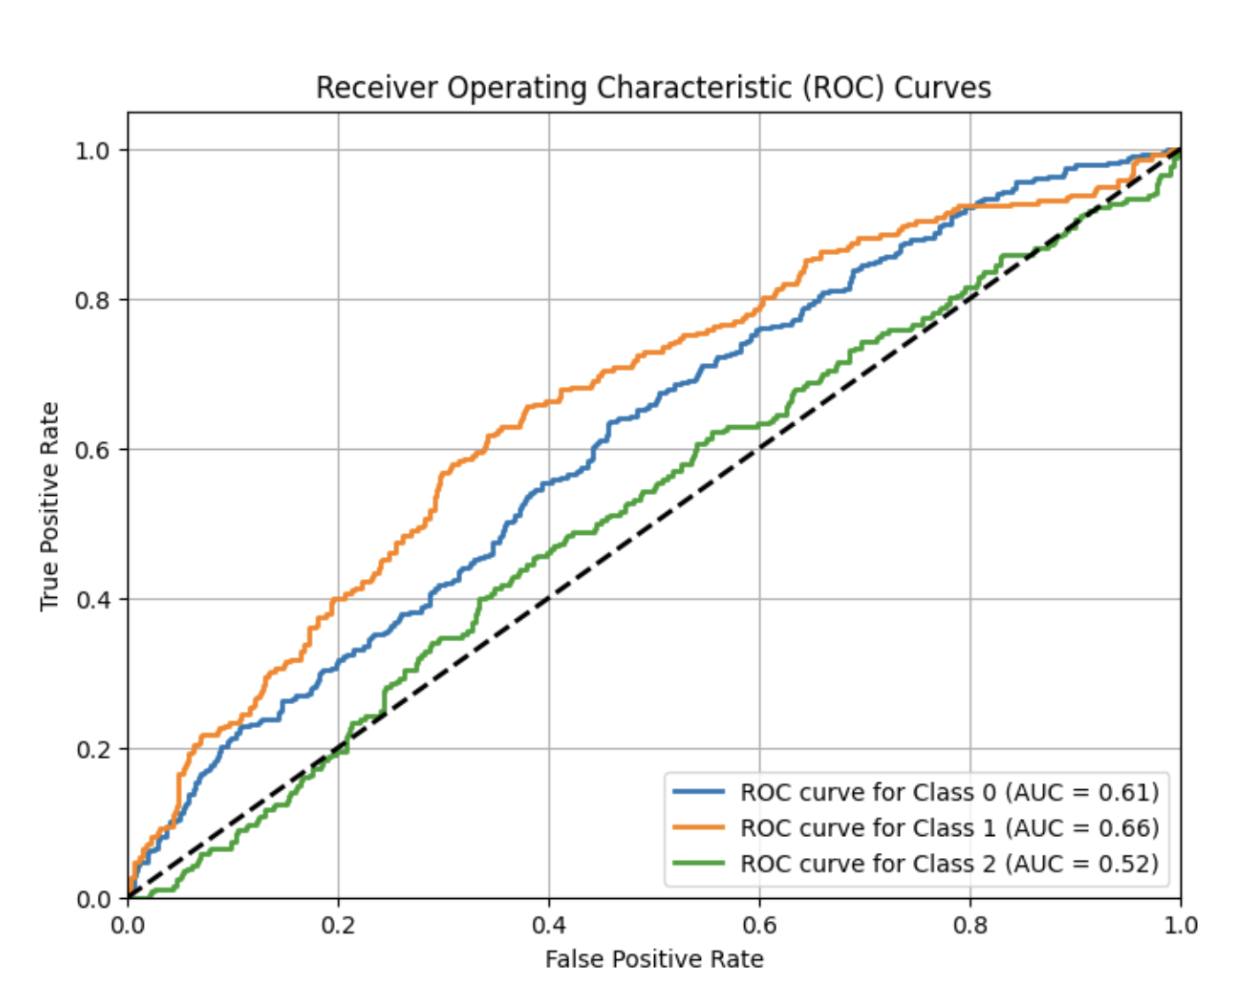